In [ ]:
import csv
import os
import pickle
import google.oauth2.credentials
 
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from google_auth_oauthlib.flow import InstalledAppFlow

In [ ]:
# The CLIENT_SECRETS_FILE variable specifies the name of a file that contains
# the OAuth 2.0 information for this application, including its client_id and
# client_secret.
CLIENT_SECRETS_FILE = "client_secret.json"

In [ ]:
# This OAuth 2.0 access scope allows for full read/write access to the
# authenticated user's account and requires requests to use an SSL connection.
SCOPES = ['https://www.googleapis.com/auth/youtube.force-ssl']
API_SERVICE_NAME = 'youtube'
API_VERSION = 'v3'

In [ ]:
def get_authenticated_service():
    credentials = None
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            credentials = pickle.load(token)
    #  Check if the credentials are invalid or do not exist
    if not credentials or not credentials.valid:
        # Check if the credentials have expired
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_console()
 
        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(credentials, token)
 
    return build(API_SERVICE_NAME, API_VERSION, credentials = credentials)

In [ ]:
def get_video_comments(service, **kwargs):
    comments = []
    results = service.commentThreads().list(**kwargs).execute()
 
    while results:
        for item in results['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(comment)
 
        # Check if another page exists
        if 'nextPageToken' in results:
            kwargs['pageToken'] = results['nextPageToken']
            results = service.commentThreads().list(**kwargs).execute()
        else:
            break
 
    return comments

In [ ]:
def write_to_csv(comments):
    with open('comments.csv', 'w') as comments_file:
        comments_writer = csv.writer(comments_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        comments_writer.writerow(['Video ID', 'Title', 'Comment'])
        for row in comments:
            # convert the tuple to a list and write to the output file
            comments_writer.writerow(list(row))

In [ ]:
def get_videos(service, **kwargs):
    final_results = []
    results = service.search().list(**kwargs).execute()
 
    i = 0
    max_pages = 3
    while results and i < max_pages:
        final_results.extend(results['items'])
 
        # Check if another page exists
        if 'nextPageToken' in results:
            kwargs['pageToken'] = results['nextPageToken']
            results = service.search().list(**kwargs).execute()
            i += 1
        else:
            break
 
    return final_results

In [ ]:
def search_videos_by_keyword(service, **kwargs):
    results = get_videos(service, **kwargs)
    final_result = []
    for item in results:
        title = item['snippet']['title']
        video_id = item['id']['videoId']
        comments = get_video_comments(service, part='snippet', videoId='n9xhJrPXop4', textFormat='plainText')
        # make a tuple consisting of the video id, title, comment and add the result to 
        # the final list
        final_result.extend([(video_id, title, comment) for comment in comments]) 
 
    write_to_csv(final_result)

In [ ]:
os.environ['OAUTHLIB_INSECURE_TRANSPORT'] = '1'

In [ ]:
if __name__ == '__main__':
    # When running locally, disable OAuthlib's HTTPs verification. When
    # running in production *do not* leave this option enabled.
    os.environ['OAUTHLIB_INSECURE_TRANSPORT'] = '1'
    service = get_authenticated_service()

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=544446730019-b385qne3d4q55hrfo360vnjo5jr39rsk.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.force-ssl&state=2fVQnyzEJIug0K8pA1v3kwq0dx47id&prompt=consent&access_type=offline
Enter the authorization code: 4/4gG76gLYDZTRKMFC2DHzFrcas7drGegW4Ze6Ys9dycMZTWMwZ4mFoXo


In [ ]:
comments = get_video_comments(service, part='snippet', videoId='n9xhJrPXop4', textFormat='plainText')

In [ ]:
len(comments)

33072

In [ ]:
comments[:5]

['LOOKS SHIT',
 'muito bom',
 "Wow can't wait 😍",
 'Will it excel the 1984 Version?\nWill there be more tracks from DSOTM?\nD. Bautista is Raban? Too polite for this character.',
 "i can't wait to be dissapointed by yet shite remake of something that made money back in the day. ruin more of my childhood memories please. why don't you fuck up space camp for me next. or cut out the middleman and rob me of hope for the future directly."]

In [ ]:
import pandas as pd

df = pd.DataFrame(data = comments, columns=['comment'])

In [ ]:
df.head()

,comment
0,LOOKS SHIT
1,muito bom
2,Wow can't wait 😍
3,Will it excel the 1984 Version?\nWill there be...
4,i can't wait to be dissapointed by yet shite r...


In [ ]:
df.shape

(33072, 1)

In [ ]:
df.to_csv('dune_comments.csv')

In [ ]:
keyword = input('Enter a keyword: ')


Enter a keyword: Dune Official Trailer


In [ ]:
search_videos_by_keyword(service, q=keyword, part='id,snippet', eventType='completed', type='video')

HttpError: ignored

In [ ]:
import pandas as pd
data = pd.read_csv('comments.csv')

In [31]:
data.tail()

,Video ID,Title,Comment
923,KHVs0PKODmQ,Dune - Official Trailer Explained in Malayalam...,🔥🔥🔥
924,KHVs0PKODmQ,Dune - Official Trailer Explained in Malayalam...,❤💖💖❤
925,KHVs0PKODmQ,Dune - Official Trailer Explained in Malayalam...,💫
926,KHVs0PKODmQ,Dune - Official Trailer Explained in Malayalam...,Kili poyi trailer kanda njan
927,KHVs0PKODmQ,Dune - Official Trailer Explained in Malayalam...,Mandalorian returns in October 30


In [ ]:
data.shape

(928, 3)

In [ ]:
data['Video ID'].value_counts()

q_rs2Uik-Zc    617
sYJwogl-p60    131
1YJqB6zSZl0     68
te_hSI6niuY     30
kU4S8lpQ-yQ     27
rvrCx3LuZvI     21
rxutwADcupI     14
KHVs0PKODmQ      8
0IhL3U2qzhY      5
2Cap4jrsB-w      3
RAVg3EPHIF0      2
qSCo7Wweb44      2
Name: Video ID, dtype: int64

In [32]:
!pip install langdetect

     |████████████████████████████████| 983kB 2.8MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=7e26cb878856131ab4d2b65ad7eae448e7636330e908f128f6948f334408c591
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [33]:
df.shape

(33072, 1)

In [34]:
from langdetect import detect

In [49]:
texl70 = df['comment']
langdet = []                                                    

for i in range(len(df)):                                         
    try:                                                          
       lang=detect(texl70[i])                                      
    except:                                                       
       lang='no' 
       df.drop(i,0,inplace=True)                                                 
       #print("This row throws error:", texl70[i])                 
    langdet.append(lang) 

In [50]:
df.shape

(32585, 1)

In [53]:
df['language'] = df.comment.apply(lambda x: detect(x))

In [54]:
df.head()

,comment,language
0,LOOKS SHIT,de
1,muito bom,pt
2,Wow can't wait 😍,en
3,Will it excel the 1984 Version?\nWill there be...,en
4,i can't wait to be dissapointed by yet shite r...,en


In [ ]:
#Plus de 500 lignes qui ne servent a rien

In [55]:
df.to_csv('clean_dune_comments.csv')

In [58]:
df.language.value_counts()

en       26784
de         729
af         531
so         393
et         334
id         315
fr         299
cy         295
tl         240
pl         230
es         204
nl         197
da         194
no         181
tr         161
pt         160
vi         154
ru         145
sw         134
it         133
ca         125
sv         101
ro          99
fi          87
hr          39
sq          38
sk          35
hu          35
ar          29
sl          28
lt          22
ml          17
bg          15
ko          15
uk          14
cs          11
hi           9
mk           9
th           7
zh-tw        7
zh-cn        6
ja           4
bn           4
lv           4
el           3
ur           3
fa           3
he           2
mr           1
Name: language, dtype: int64

In [64]:
df[df.language=='es']

,comment,language
194,Abran los putos cines de mi país,es
554,"Sueño frustrado de venezolano, nunca fui a dun...",es
604,Vine xq me lo recomendaron en Tiktok,es
671,Pero bueno el casting de esta peli está buenísimo,es
705,"Se ve perrísima weyyyy, además sale mi novio.",es
...,...,...
33022,Second♥️,es
33025,Second,es
33055,Second,es
33060,Second,es


In [56]:
import seaborn as sns

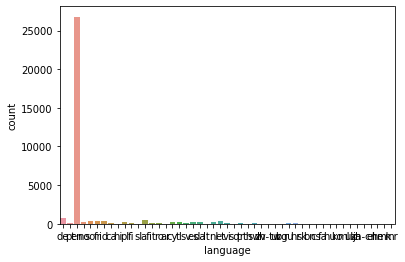

In [57]:
sns.countplot(x='language',data=df)

In [65]:
!pip install textblob

In [66]:
from textblob import TextBlob

In [68]:
def lang_detector(x):
  x=TextBlob(x)
  return x.detect_language()

In [72]:
df['taille'] = df.comment.apply(lambda x: len(x))

In [73]:
df.head()

,comment,language,taille
0,LOOKS SHIT,de,10
1,muito bom,pt,9
2,Wow can't wait 😍,en,16
3,Will it excel the 1984 Version?\nWill there be...,en,122
4,i can't wait to be dissapointed by yet shite r...,en,255


In [74]:
df=df[df.taille > 3]

In [76]:
df['lang'] = df.comment.apply(lang_detector)

HTTPError: ignored